# **Decision Tree Model** for Outcome Prediction of Intracranial Aneurysm Treatment with Flow Diverters


### Imports

In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.ensemble
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

### Data Preparation

In [2]:
dataframe = pd.read_csv("primary_features.csv")
#dataframe.head()

In [3]:
# Create feature and label dataframes
features = dataframe.drop('outcome', axis='columns')
labels = dataframe['outcome']

In [4]:
# Encode 'side' feature column
lb_enc_side = LabelEncoder()
features['side_n'] = lb_enc_side.fit_transform(features['side'])
features = features.drop(['side'],axis='columns')

In [5]:
#Names for features and labels
feature_names = features.columns.tolist()
label_names = ["Unsuccessful","Successful"]

### Create Training & Test Sets

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=0.2)
print(len(x_train), 'train examples')
print(len(x_test), 'test examples')

65 train examples
17 test examples


### Model (with test set)

In [7]:
model = tree.DecisionTreeClassifier()

model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [8]:
model.score(x_test,y_test)

0.7647058823529411

### Model (without test set)

In [10]:
model_f = tree.DecisionTreeClassifier()
model_f.fit(features,labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
model_f.score(features,labels)

1.0

### Individual Predictions

In [13]:
model.predict([[63,1,8.755372,5.7565814,4.977675,1.156480,103.502236,108.831289,17.110892,0.222524,1.614411,1]])

array([0])

In [14]:
model.predict([[50,1,5.185685,3.415747,4.034782,0.846575,39.599791,51.760595,10.735090,0.138471,0.0,0]])

array([1])

### Visualised Trees

In [15]:
# Visualises the tree using graphviz
def print_tree(model,feat,lbl):
  export_graphviz(model, out_file='tree.dot', 
                feature_names = feat,
                class_names = lbl,
                rounded = True, proportion = False, 
                precision = 2, filled = True,
                special_characters=True)
  call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
  return Image(filename = 'tree.png')

In [ ]:
tree.plot_tree(model)

In [ ]:
tree.plot_tree(model_f)

In [16]:
print_tree(model,feature_names,label_names)

## LIME

In [17]:
!pip install lime

import lime
import lime.lime_tabular

     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=92f0ec6cf1cb9ca149b455fbbdaa023a68f64a202240e3b6acb2b03c2a07cd7a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [18]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=x_train.to_numpy(),
                                                   feature_names=feature_names,
                                                   training_labels=feature_names,
                                                   class_names=label_names,
                                                   discretize_continuous=True)

np_test = x_test.to_numpy()

In [19]:
def explain(i):
  exp = explainer.explain_instance(np_test[i],predict_fn=model.predict_proba,num_features=len(feature_names))
  exp.show_in_notebook(show_table=True, show_all=False)

In [20]:
explain(11)

### Test case: Single Instance

In [21]:
i = np.array([63,1,5.24943,4.160908,4.321835,0.962764,30.63648,44.92163,12.3341,0.163413,0.962034,1])
ei = explainer.explain_instance(i,predict_fn=model.predict_proba,num_features=len(feature_names))
ei.show_in_notebook(show_table=True, show_all=False)

## SHAP


In [22]:
!pip install shap

import shap

     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394143 sha256=f95e91edb8e865268470f3b639ccb06e58b35738280d81ffc6cdf41c26167583
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [23]:
shap.initjs()

e = shap.TreeExplainer(model)

# Prediction-level Interpretation
shap_values = e.shap_values(x_test.iloc[4,:])
shap.force_plot(e.expected_value[0], shap_values[0], x_test.iloc[4,:])


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [24]:
shap.initjs()

# Dataset-level Interpretation
k_shap_values = e.shap_values(x_test)
shap.force_plot(e.expected_value[0], k_shap_values[0], x_test)

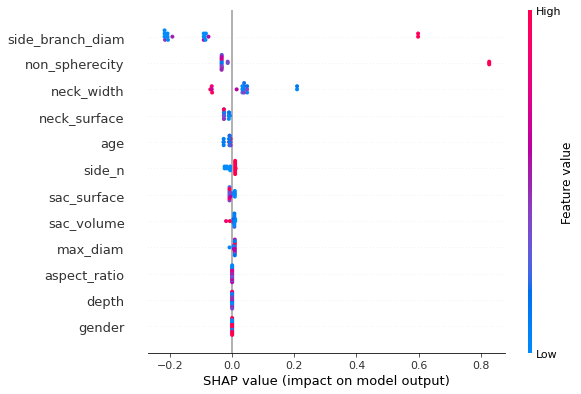

In [25]:
# summarize the effects of all the features
shap.summary_plot(k_shap_values[0], x_test)

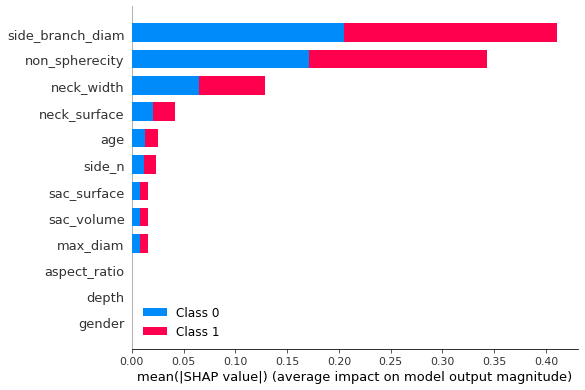

In [26]:
# summarize the effects of all the features
shap.summary_plot(k_shap_values, x_test)

## ELI5

In [27]:
!pip install eli5

import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 3.4MB/s 


The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [28]:
eli5.show_weights(model, feature_names=feature_names,target_names=label_names)

In [29]:
eli5.show_prediction(model,x_test.iloc[0],feature_names=feature_names,target_names=label_names, show_feature_values=True)

In [30]:
perm = PermutationImportance(model).fit(x_test,y_test)
eli5.show_weights(perm, feature_names=feature_names, target_names=label_names)